# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `/home2/ajv85/hw3-help`


In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

#### Problem Solution
The differential equation for the concentration of DO in this river can be modeled as follows:<br>
$ \frac{Q}{A}\frac{dC_{DO}}{dx} = - k_{c}C_{c} - k_{n}C_{n} + k_a(C_{DO}^* - C_{DO})$ <br>
Where:<br>
$ C_{c} = C_{c0} e^{-k_{c}t} $ <br>
$ C_{n} = C_{n0} e^{-k_{n}t} $ <br>
And: <br>
$ t = x/u $<br>
$ \frac{Q}{A} = u = 6 \; km/d $ <br><br>

The resulting integrated differential equation is as follows:<br>
$ C_{DO}(x) = C_{DO}^* + (C_{DO0} - C_{DO}^*)e^{-k_ax/u} - C_{c0}(\frac{k_c}{k_a - k_c})(e^{-k_cx/u} - e^{-k_ax/u}) - C_{n0}(\frac{k_n}{k_a - k_n})(e^{-k_nx/u} - e^{-k_ax/u})$ <br><br>

Next, this DO concentration equation can be applied across two discrete domains, x = [0, 15) and x = [15, $\infty{}$) taking into account the following initial conditions for each domain.<br>
**x = [0, 15)** <br>
$ C_{DO}^* = 10 \; mg/L $ <br>
$ u = 6 \; km/d $ <br>
$ k_a = 0.55 \; d^{-1} $ <br>
$ k_c = 0.35 \; d^{-1} $ <br>
$ k_n = 0.25 \; d^{-1} $ <br>
$ C_{DO0} = \frac{100,000*7.5 + 10,000*5}{100,000 + 10,000} = 7.273 \; mg/L $ <br>
$ C_{c0} = \frac{100,000*5 + 10,000*50}{100,000 + 10,000} = 9.091 \; mg/L $ <br>
$ C_{n0} = \frac{100,000*5 + 10,000*35}{100,000 + 10,000} = 7.728 \; mg/L$ <br><br>

**x = [15, $\infty{}$)** <br>
$ C_{DO}^* = 10 \; mg/L $ <br>
$ u = 6 \; km/d $ <br>
$ k_a = 0.55 \; d^{-1} $ <br>
$ k_c = 0.35 \; d^{-1} $ <br>
$ k_n = 0.25 \; d^{-1} $ <br>
$ C_{DO0} = \frac{110,000*4.882 + 15,000*5}{110,000 + 15,000} = 4.896 \; mg/L $ <br>
$ C_{c0} = \frac{110,000*3.790 + 15,000*45}{110,000 + 15,000} = 8.735 \; mg/L $ <br>
$ C_{n0} = \frac{110,000*4.136 + 15,000*35}{110,000 + 15,000} = 7.840 \; mg/L$ <br><br>

Below is the code that implements the equations across the two domains for the initial conditions described above.

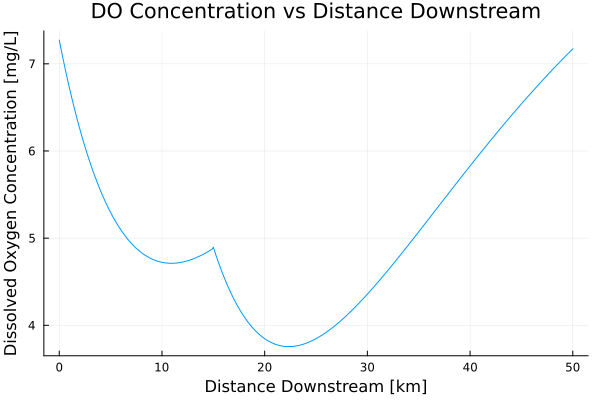

The minimum DO value is: 3.76 mg/L with no removal.
--------------------------------------------------------------------------



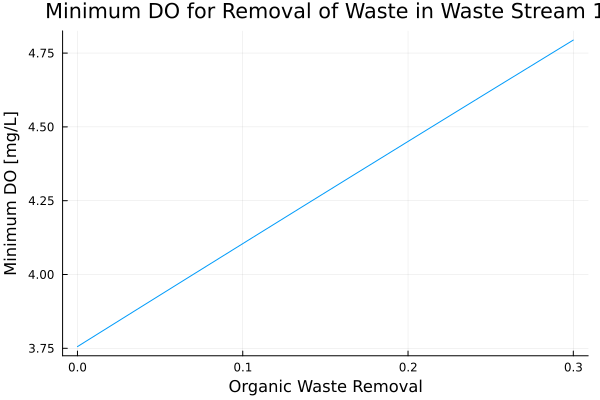

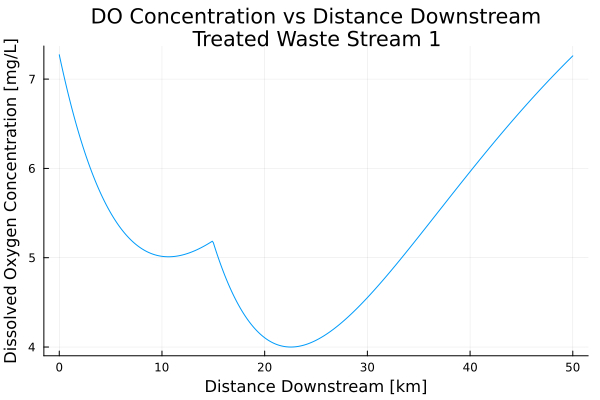

The minimum DO value is constrained to a value >= 4 mg/L when the removal of organic waste from stream 1 = 7.0%.
--------------------------------------------------------------------------n


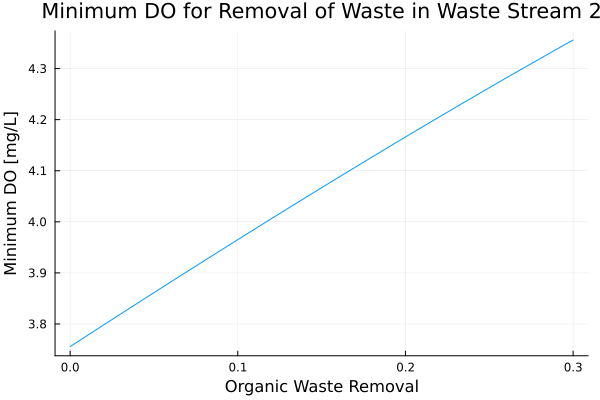

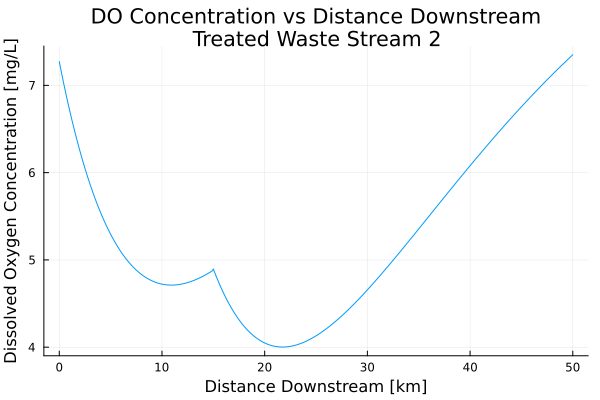

The minimum DO value is constrained to a value >= 4 mg/L when the removal of organic waste from stream 2 = 11.8%.




In [3]:
function dissolved_oxygen(CDO0, Cc0, Cn0, x) # function to solve dissolved oxygen given initial concentrations at some x downstream
    CDOs = 10 # mg/L
    u = 6 # km/d
    ka = 0.55 # 1/d
    kc = 0.35 # 1/d
    kn = 0.25 # 1/d

    alpha1 = exp(-1 * ka * x / u)
    alpha2 = (kc/(ka-kc)) * (exp(-1 * kc * x / u) - exp(-1 * ka * x / u))
    alpha3 = (kn/(ka-kn)) * (exp(-1 * kn * x / u) - exp(-1 * ka * x / u))

    return CDOs*(1 - alpha1) + CDO0*alpha1 - Cc0*alpha2 - Cn0*alpha3
end

function complete_dissolved_oxygen(x, r1, r2) # x is the distance downstream of the initial point, r1 is the % removal of waste 1, r2 is the % removal of waste 2
    CDO0_1 = 80/11 # mg/L
    Cc0_1 = (100/11) * (1 - r1) # mg/L
    Cn0_1 = (85/11) * (1 - r1) # mg/L

    CDO0_2 = (110000*dissolved_oxygen(CDO0_1, Cc0_1, Cn0_1, 15) + 15000*5) / 125000 # mg/L
    Cc0_2 = (110000*Cc0_1*exp(-1 * 0.35 * 2.5) + 15000*45*(1 - r2)) / 125000 # mg/L
    Cn0_2 = (110000*Cn0_1*exp(-1 * 0.25 * 2.5) + 15000*35*(1 - r2)) / 125000 # mg/L

    if x < 15
        return dissolved_oxygen(CDO0_1, Cc0_1, Cn0_1, x)
    else
        return dissolved_oxygen(CDO0_2, Cc0_2, Cn0_2, x - 15)
    end
end

function DO_curve(start, interval, finish, r1, r2) # Function to solve for an array over some interval of DO values given some removal rate
    X = []
    DO = []
    for x in start:interval:finish
        append!(X, x)
        append!(DO, complete_dissolved_oxygen(x, r1, r2))
    end
    return (X, DO)
end

# Calculate and plot the DO curve given 0.1 time steps and no removal
(X, DO) = DO_curve(0, 0.1, 50, 0, 0)

p1 = plot(X, DO, title = "DO Concentration vs Distance Downstream", legend = false)
xlabel!("Distance Downstream [km]")
ylabel!("Dissolved Oxygen Concentration [mg/L]")
display(p1)
print("The minimum DO value is: " * string(round(minimum(DO), digits = 2)) * " mg/L with no removal.\n--------------------------------------------------------------------------\n\n")

# ----------------------------------------------------------------------------------------------------------------

# Apply the same as above for a set of removal rates for stream 1
R1 = []
min_r1 = []
for r1 in 0:0.001:0.3
    (X, DO) = DO_curve(0, 0.1, 50, r1, 0)
    append!(R1, r1)
    append!(min_r1, minimum(DO))
end

p2 = plot(R1, min_r1, title = "Minimum DO for Removal of Waste in Waste Stream 1", legend = false)
xlabel!("Organic Waste Removal")
ylabel!("Minimum DO [mg/L]")
display(p2)

# Determine the minimum removal rate for a minimum DO of 4 mg/L
i = 1
check = 0
r1_min = 0
while check <= 4
    check = min_r1[i]
    r1_min = R1[i]
    i = i + 1
end

(X, DO) = DO_curve(0, 0.1, 50, r1_min, 0)

p3 = plot(X, DO, title = "DO Concentration vs Distance Downstream\nTreated Waste Stream 1", legend = false)
xlabel!("Distance Downstream [km]")
ylabel!("Dissolved Oxygen Concentration [mg/L]")
display(p3)

print("The minimum DO value is constrained to a value >= 4 mg/L when the removal of organic waste from stream 1 = " * string(round(r1_min*100, digits = 2)) * "%.\n--------------------------------------------------------------------------n\n")

# ---------------------------------------------------------------------------------------------------------------

# Apply the same as above for a set of removal rates for stream 2
R2 = []
min_r2 = []
for r2 in 0:0.001:0.3
    (X, DO) = DO_curve(0, 0.1, 50, 0, r2)
    append!(R2, r2)
    append!(min_r2, minimum(DO))
end

p4 = plot(R2, min_r2, title = "Minimum DO for Removal of Waste in Waste Stream 2", legend = false)
xlabel!("Organic Waste Removal")
ylabel!("Minimum DO [mg/L]")
display(p4)

# Determine the minimum removal rate for a minimum DO of 4 mg/L
i = 1
check = 0
r2_min = 0
while check <= 4
    check = min_r2[i]
    r2_min = R2[i]
    i = i + 1
end

(X, DO) = DO_curve(0, 0.1, 50, 0, r2_min)

p5 = plot(X, DO, title = "DO Concentration vs Distance Downstream\nTreated Waste Stream 2", legend = false)
xlabel!("Distance Downstream [km]")
ylabel!("Dissolved Oxygen Concentration [mg/L]")
display(p5)

print("The minimum DO value is constrained to a value >= 4 mg/L when the removal of organic waste from stream 2 = " * string(round(r2_min*100, digits = 2)) * "%.\n\n\n")

Given a mandate to maintain DO concentration above 4 mg/L, I would need to know the cost of treatment of each stream. Difference in location and contaminants in each waste stream could result in differing costs of treatment and thus prove either treatment of both streams equally, or treatment of just stream 2 as the cheaper option. This decision is only possible given that the DO minimum that results from just stream 1 does not dip below 4 mg/L, and thus it is possible to solve this DO dip through treatment of either both streams, or just one.

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [4]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  0.2624881820283316
  0.2610752608567423
 -0.6636468288148648
  ⋮
 12.644957915496068
 12.642990730156399
 12.640949277624589
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

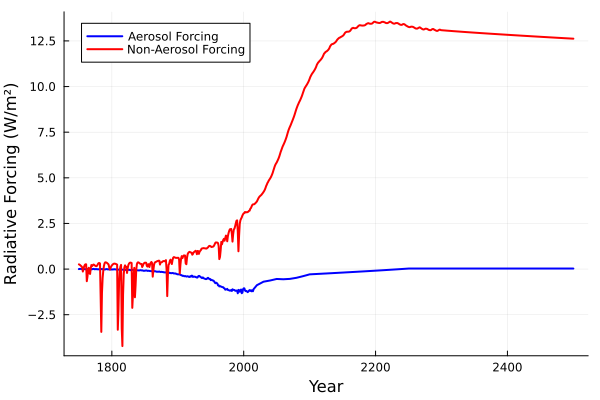

In [5]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

#### Problem Solution
$ cd\frac{dT}{dt} = F-\lambda T $ <br>
$c = 4.184\times 10^6 \; \mathrm{J/K/m}^2$ <br>
$ d = 86 \;\mathrm{m} $<br>
$ F = F_\text{non-aerosol} + \alpha F_\text{aerosol} $<br>
$ \alpha = 0.8 $ <br>
$ \lambda = 2.1 \; ^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$ <br><br>

Discretized: <br>
$ T(t + \Delta t) = T(t) + \Delta t * \frac{F - \lambda T(t)}{cd}$<br>
$ \Delta t = 31,558,152 \; s $ <br>
$ T(0) = 0 \; ^\circ C $ <br><br>

Using this temperature discretization, global mean temperature difference from 1750 was calculated until year 2400 and plotted below. Then, lambda was replaced with a LogNormal distribution and a Monte Carlo simulation of n = 2000 was run, and an expected value was produced.

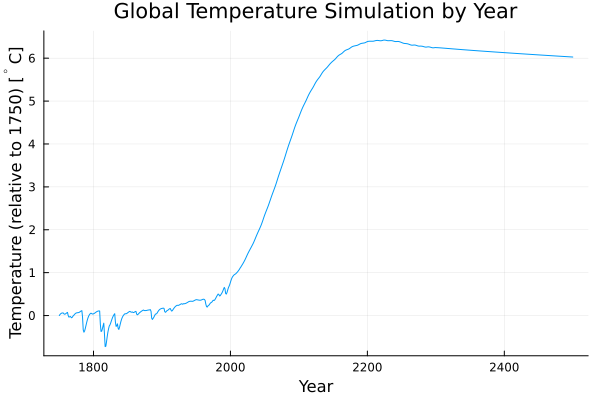

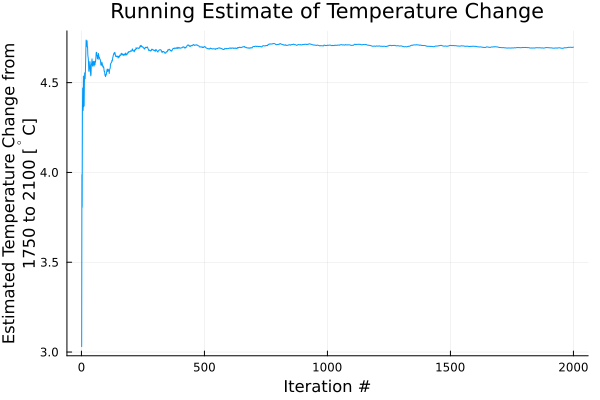

The expected global temperature by 2100 using Monte Carlo simulation is 4.6975+-0.0163 C.
The difference between this estimate and the original estimate given a lambda = 2.1 is 0.065 C.

In [6]:
# Set initial values
T = [0.0]
Year = [1750]
c = 4.184 * 10^6
d = 86
alpha = 0.8
lambda = 2.1
dt = 31558152

# Calculate Temperature changes through time using the discretized equation
for i in 1:750
    append!(Year, 1750 + i)
    F = forcing_non_aerosol[i] + alpha*forcing_aerosol[i]
    new_T = T[i] + dt*((F - lambda*T[i]) / (c*d))
    append!(T, new_T)
end

Tvalue2100 = T[351]

p1 = plot(Year, T, title = "Global Temperature Simulation by Year", legend = false)
xlabel!("Year")
ylabel!("Temperature (relative to 1750) [" * L"^\circ" * "C]")
display(p1)

# --------------------------------------------------------------------------------------------------------------------------------------------

# Apply the same as above for a variety of lambda values across a LogNormal distribution
lambda_dist = LogNormal(log(2.1), log(2)/4)

n = 2000
T2100 = []
Running_estimate = []
iteration = []

for n in 1:n
    T = 0.0
    lambda = rand(lambda_dist)
    for i in 1:350
        F = forcing_non_aerosol[i] + alpha*forcing_aerosol[i]
        new_T = T + dt*((F - lambda*T) / (c*d))
        T = new_T
    end
    append!(T2100, T)
    append!(Running_estimate, sum(T2100)/length(T2100))
    append!(iteration, n)
end

p2 = plot(iteration, Running_estimate, title = "Running Estimate of Temperature Change", legend = false)
xlabel!("Iteration #")
ylabel!("Estimated Temperature Change from\n1750 to 2100 [" * L"^\circ" * "C]")
display(p2)

# Compare the original and Monte Carlo simulation estimates
mean = sum(T2100)/length(T2100)
s = std(T2100)
pm = 0.95*(s/sqrt(n))

print("The expected global temperature by 2100 using Monte Carlo simulation is " * string(round(mean, digits = 4)) * "+-" * string(round(pm, digits = 4)) * " C.\n")
print("The difference between this estimate and the original estimate given a lambda = 2.1 is " * string(round(mean - Tvalue2100, digits = 4)) * " C.")

Interestingly, the temperature change from 1750 to 2100 given a lambda of 2.1 is only slightly lower than the estimated value using a LogNormal lambda distribution, but is outside of the 95% confidence interval. <br> <br>
I decided that my sample set was sufficiently large when my running estimate plot began to show minimal change through increased iterations. This meant that my n was sufficiently large enough that there was only very minor change in estimated temperature change from 1750 to 2100 due to each iteration.

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.